In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
from cv2 import xfeatures2d
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
def load_image(image_path):
    return cv2.imread(image_path)

In [4]:
def statistic():
    label = []
    num_images = []
    for lab in os.listdir('trainingset'):
        label.append(lab)
        num_images.append(len(os.listdir(os.path.join('trainingset', lab))))

    return label, num_images

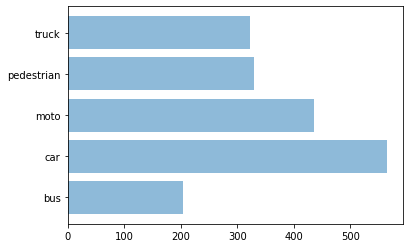

Total images: 1855


In [5]:
label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

In [6]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir('trainingset'):
        for img_file in os.listdir(os.path.join('trainingset', label)):
        
            img = load_image(os.path.join('trainingset', label, img_file))
            X.append(img)
            Y.append(label2id[label])
    return X, Y

In [7]:
# Label to id, used to convert string label to integer 
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
print(X[0].shape)
print(Y[0])

1855
1855
(168, 134, 3)
4


## Câu hỏi 2: Trích xuất đặc trưng (features extraction)

Ở câu hỏi này chúng ta sẽ lần lượt thực hiện các công việc: trích xuất đặc trưng SIFT (SIFT keypoints descriptor), xây dựng từ điển và mô hình Bag-of-Word (BoW). Bạn hãy lập trình hoàn chỉnh các hàm theo yêu cầu cụ thể dưới đây

### Câu hỏi 2.1: Trích xuất đặc trưng SIFT

Hãy lập trình hàm extract_sift_features() nhận đầu vào là list ảnh ta đã xây dựng được từ câu hỏi trước và trả về list image_descriptors, phần tử thứ p trong list image_descriptors lại là một list chứa các SIFT keypoints descriptor ứng với ảnh thứ p trong list X.

Gợi ý: Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create(). Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. Chúng ta sẽ dùng các des này để phục vụ bài toán phân loại.

In [8]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()

    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i], None)
    
        image_descriptors.append(des)
        

    return image_descriptors

In [9]:
image_descriptors = extract_sift_features(X)
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1855
<class 'numpy.ndarray'>
Image 0 has 109 descriptors
Image 1 has 148 descriptors
Image 2 has 57 descriptors
Image 3 has 29 descriptors
Image 4 has 83 descriptors
Image 5 has 28 descriptors
Image 6 has 219 descriptors
Image 7 has 22 descriptors
Image 8 has 62 descriptors
Image 9 has 181 descriptors


### Câu hỏi 2.2: Xây dựng từ điển
Hãy lập trình hàm kmeans_bow() nhận đầu vào là một list gồm tất cả các descriptors của các ảnh trong tập X và số cụm num_clusters, sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm. Hàm trả về một danh sách center của các cụm. Vì thao tác này mất rất nhiều thời gian nên ta sẽ lưu danh sách trả về bởi hàm kmeans_bow() ra một file nhị phân (sử dụng thư viện pickle) để tiện sử dụng sau này.

Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors:

In [10]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 171045


Hãy lập trình hàm kmeans_bow().

Gợi ý: Trong thư viện sklearn, để khởi tạo một đối tượng kmeans ta sử dụng lệnh:
kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)

Đối tượng kmeans có phương thức fit, nhận vào các điểm dữ liệu (trong bài toán hiện tại của chúng ta là list all_descriptors) và tìm ra n_clusters vector là tâm của các cụm dữ liệu. Để lấy được các vector này ta sử dụng thuộc tính $cluster_centers_$  của đối tượng kmeans

In [11]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []
    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

In [12]:
num_clusters = 5
if not os.path.isfile('bow_dictionary150.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary150.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary150.pkl', 'rb'))
    
print(len(BoW))
print(type(BoW[0]))

5
<class 'numpy.ndarray'>


### Câu hỏi 2.3: Xây dựng vector đặc trưng với mô hình BoW

Hãy xây dựng hàm create_features_bow() nhận đầu vào là list image_descriptors, list BoW và num_clusters ở trên, trả về list X_features, trong đó phần tử thứ p của X_vectors là vector đặc trưng theo mô hình BoW ứng với ảnh thứ p, tập keypoint descriptors thứ p. Hãy chú ý sự tương ứng các phần tử trong 4 danh sách: X, Y, image_descriptors, X_features.

In [13]:
from scipy.spatial.distance import cdist

In [14]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
        
            argmin = np.argmin(distance, axis=1)
            
            for j in argmin:
                features[j] += 1
            

        X_features.append(features)


    return X_features

In [15]:
print(image_descriptors[0].shape)
print(BoW[0].shape)
X_features = create_features_bow(image_descriptors, BoW, num_clusters)
print(len(X_features))
print(X_features[0])
print(sum(X_features[0]))
print(image_descriptors[0].shape[0])

(109, 128)
(128,)
1855
[17 13 22 20 37]
109
109


## Câu hỏi 3: Xây dựng mô hình
Từ các câu hỏi trước chúng ta đã xây dựng được vector đặc trưng ứng với mỗi ảnh trong bộ dữ liệu. Ở câu hỏi này chúng ta sẽ xây dựng các mô hình phân loại SVM

In [16]:
print(len(X_features))
print(len(Y))

1855
1855


Chia tập dữ liệu thành tập train/test:

In [17]:
from sklearn.model_selection import train_test_split

X_train = [] 
X_test = []
Y_train = []
Y_test = []
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

1484
371


Khai báo đối tượng SVM:

In [18]:
svm = sklearn.svm.SVC(C = 30)
print(svm)

SVC(C=30)


Huấn luyện, kiểm tra độ chính xác của mô hình tương tự như các bài học trước (sử dụng các hàm fit, predict, score,... của đối tượng svm)

Huấn luyện mô hình:

In [19]:
svm.fit(X_train, Y_train)

SVC(C=30)

Tính độ chính xác trên tập dữ liệu huấn luyện:

In [20]:
svm.score(X_train, Y_train)

0.6212938005390836

Tính độ chính xác trên tập dữ liệu test:

In [21]:
svm.score(X_test, Y_test)

0.5983827493261455

## Câu hỏi 4: Dùng mô hình đã huấn luyện dự đoán hình ảnh thực tế

Cuối cùng ta sẽ dùng thử mô hình đã huấn luyện để đưa ra dự đoán về một hình ảnh thực tế. Chúng ta sẽ làm lần lượt các bước: đọc ảnh, trích xuất đặc trưng BoW của ảnh, dự đoán sử dụng mô hình đã huấn luyện.

__Bước 1__: Đọc ảnh ở đường dẫn image_test/car.png, lưu ảnh vào biến img

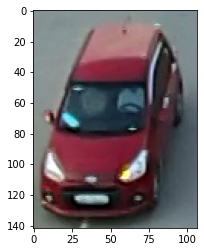

In [22]:
img = None


img = load_image('image_test/car.png')


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

my_X = [img]

__Bước 2__: Trích xuất đặc trưng SIFT (lưu vào biến my_image_descriptors) và BoW (lưu vào biến my_X_features) từ my_X:

In [23]:
my_image_descriptors = None
my_X_features = None


my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)


print(len(my_image_descriptors))
print(my_X_features[0].shape)

1
(5,)


__Bước 3:__ Sử dụng mô hình đã huấn luyện để dự đoán, kết quả dự đoán lưu vào biến my_y_pred

In [24]:
y_pred = None


y_pred = svm.predict(my_X_features)
print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
for key, value in label2id.items():
    if value == y_pred[0]:
        print('Your prediction: ', key)

[3]
{'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
Your prediction:  car
